In [19]:
from fastccm import PairwiseCCM, ccm_utils, utils
import numpy as np
import matplotlib.pyplot as plt
import pyEDM 
import pandas as pd 

import numpy as np
import matplotlib.pyplot as plt

def plot_ccm_agreement(
    fast_vals,
    pyedm_vals,
    bins=20,
    clamp=(-1, 1),
    figsize=(15, 4),
    title_prefix="FastCCM vs pyEDM",
    show=True,
):
    fast = np.asarray(fast_vals, dtype=float).ravel()
    pyedm = np.asarray(pyedm_vals, dtype=float).ravel()
    if fast.shape != pyedm.shape:
        raise ValueError(f"Shape mismatch: {fast.shape} vs {pyedm.shape}")

    diff    = fast - pyedm
    absdiff = np.abs(diff)

    # Summary metrics
    mae   = absdiff.mean()
    rmse  = np.sqrt((diff**2).mean())
    medae = np.median(absdiff)
    p95   = np.percentile(absdiff, 95)
    mx    = absdiff.max()
    r     = np.corrcoef(pyedm, fast)[0, 1]
    slope, intercept = np.polyfit(pyedm, fast, 1)

    metrics = dict(
        n=len(fast),
        MAE=mae,
        RMSE=rmse,
        median_abs_error=medae,
        p95_abs_error=p95,
        max_abs_error=mx,
        parity_r=r,
        parity_slope=slope,
        parity_intercept=intercept,
    )

    # --- 3-panel figure ---
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # 1) Parity plot
    axes[0].scatter(pyedm, fast, s=20, alpha=0.7)
    if clamp is not None:
        axes[0].plot(clamp, clamp, linestyle="--")
        xg = np.linspace(clamp[0], clamp[1], 200)
        axes[0].set_xlim(*clamp); axes[0].set_ylim(*clamp)
    else:
        lo = min(pyedm.min(), fast.min()); hi = max(pyedm.max(), fast.max())
        axes[0].plot([lo, hi], [lo, hi], linestyle="--")
        xg = np.linspace(lo, hi, 200)
    axes[0].plot(xg, intercept + slope * xg)
    axes[0].set_xlabel("pyEDM correlation"); axes[0].set_ylabel("FastCCM correlation")
    axes[0].set_title(f"{title_prefix} — Parity (r={r:.3f})")

    # 2) Error histogram
    axes[1].hist(diff, bins=bins)
    axes[1].axvline(0, linestyle="--")
    axes[1].set_xlabel("Error (FastCCM − pyEDM)")
    axes[1].set_ylabel("Count")
    axes[1].set_title(f"Error hist (RMSE={rmse:.2e}, MAE={mae:.2e})")

    # 3) Bland–Altman
    mean_vals = 0.5 * (fast + pyedm)
    md  = diff.mean()
    sd  = diff.std(ddof=1)
    axes[2].scatter(mean_vals, diff, s=20, alpha=0.7)
    axes[2].axhline(md, linestyle="-")
    axes[2].axhline(md + 1.96 * sd, linestyle="--")
    axes[2].axhline(md - 1.96 * sd, linestyle="--")
    axes[2].set_xlabel("Mean correlation")
    axes[2].set_ylabel("FastCCM − pyEDM")
    axes[2].set_title("Bland–Altman")

    plt.tight_layout()
    if show:
        plt.show()

    # Optional: separate log10|error| figure
    fig2 = plt.figure(figsize=(5, 4))
    plt.hist(np.log10(absdiff + 1e-12), bins=bins)
    plt.xlabel("log10(|FastCCM − pyEDM|)")
    plt.ylabel("Count")
    plt.title("log10 absolute error")
    plt.tight_layout()
    if show:
        plt.show()

    return metrics, (fig, axes)

In [20]:
ccm = PairwiseCCM(device="cpu")
np.random.seed(1)

In [33]:
X_to_Y_res_FastCCM = []
X_to_Y_res_pyEDM = []

np.random.seed(1)

for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                                Y_emb = Y_emb,
                                                library_size = 200,
                                                sample_size = 200, exclusion_window=4, tp=0, method="simplex",seed=1,trials=1, nbrs_num=4)

    pyedm_ccm_res = pyEDM.CCM(df,columns="X",target="Y",libSizes="200", sample=1, E=3, tau=-1, exclusionRadius=4,seed=1, knn=4, noTime=True).to_numpy()

    X_to_Y_res_FastCCM += [fast_ccm_res[-1].squeeze()]
    X_to_Y_res_pyEDM += [pyedm_ccm_res[-1,1]]


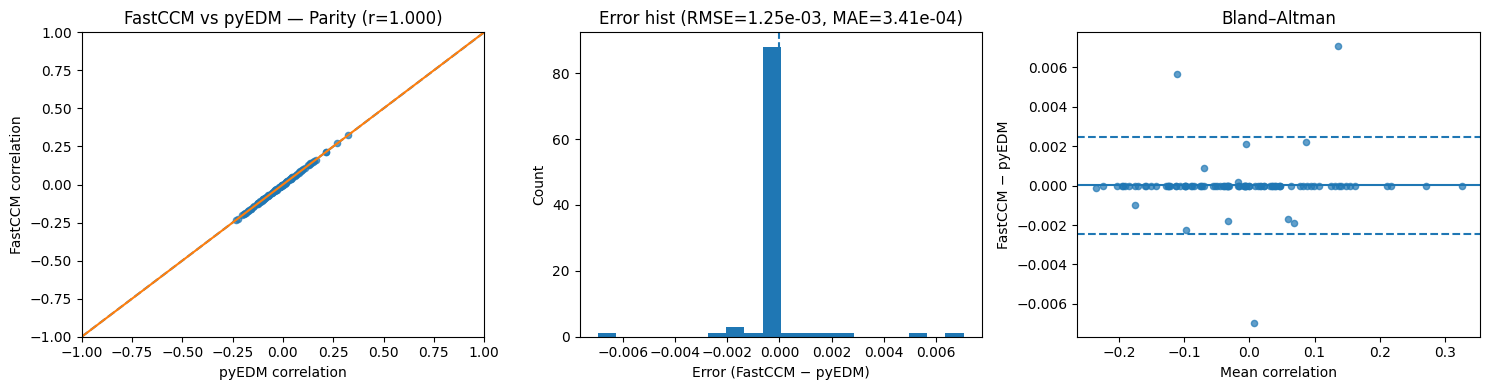

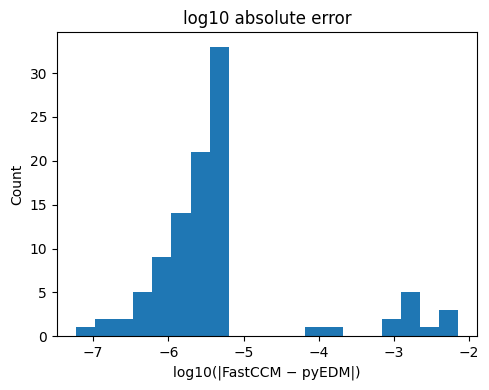

In [34]:
metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)


In [35]:
X_to_Y_res_FastCCM = []
X_to_Y_res_pyEDM = []

np.random.seed(1)

for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                                Y_emb = Y_emb,
                                                library_size = 200,
                                                sample_size = 200, exclusion_window=0, tp=1, method="simplex",seed=1, trials=1, nbrs_num=10)

    pyedm_ccm_res = pyEDM.Simplex(df,columns="X",target="Y",lib="1 200", pred="1 200", E=3, tau=-1, Tp=1, noTime=True, knn=10)

    X_to_Y_res_FastCCM += [fast_ccm_res[-1].squeeze()]
    X_to_Y_res_pyEDM += [pyedm_ccm_res[["Observations", "Predictions"]].corr()["Predictions"]["Observations"]]


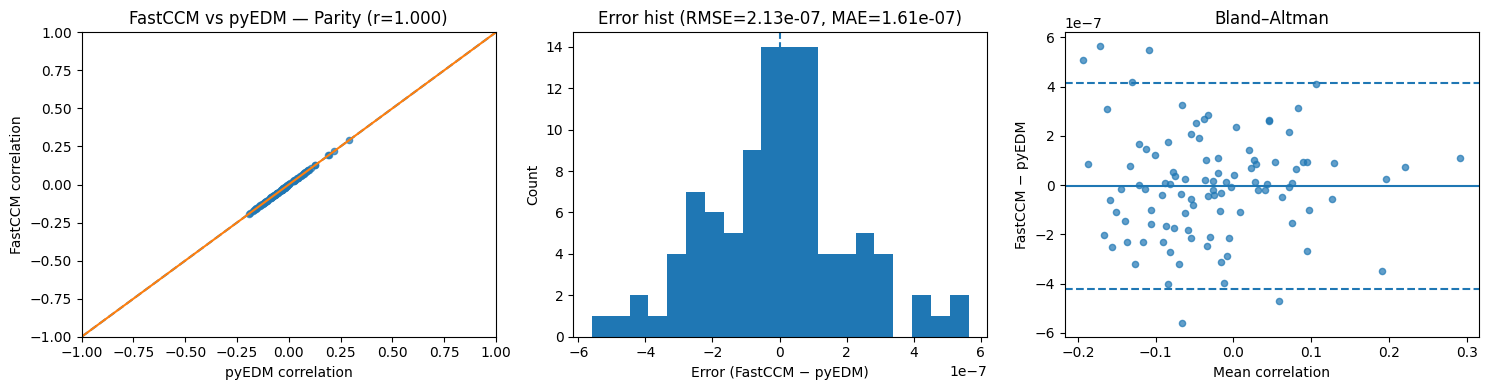

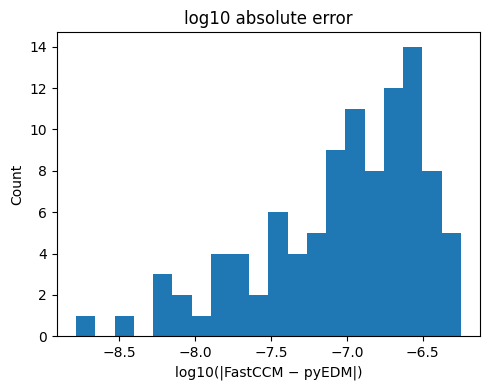

In [36]:
metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)


In [37]:
X_to_Y_res_FastCCM = []
X_to_Y_res_pyEDM = []

np.random.seed(4)
tp = 1
for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = Y[None,-X_emb.shape[1]:,None]

    fast_ccm_res = PairwiseCCM("cpu").predict(X_lib_emb = X_emb[:,0:98],
                                                Y_lib_emb = Y_emb[:,0:98],
                                                X_pred_emb = X_emb[:,98:-tp],
                                                library_size = 300, exclusion_window=None, tp=tp, method="simplex",seed=1, trials=1, nbrs_num=4)


    pyedm_ccm_res = pyEDM.Simplex(df,columns="X",target="Y",lib="1 100", pred="101 200", E=3, tau=-1, Tp=tp, noTime=True, knn=4, exclusionRadius=0)

    X_to_Y_res_FastCCM += [np.corrcoef(fast_ccm_res[:,-1,0,0], Y[100 + tp:])[0,1]]
    X_to_Y_res_pyEDM += [pyedm_ccm_res[["Observations", "Predictions"]].corr()["Predictions"]["Observations"]]


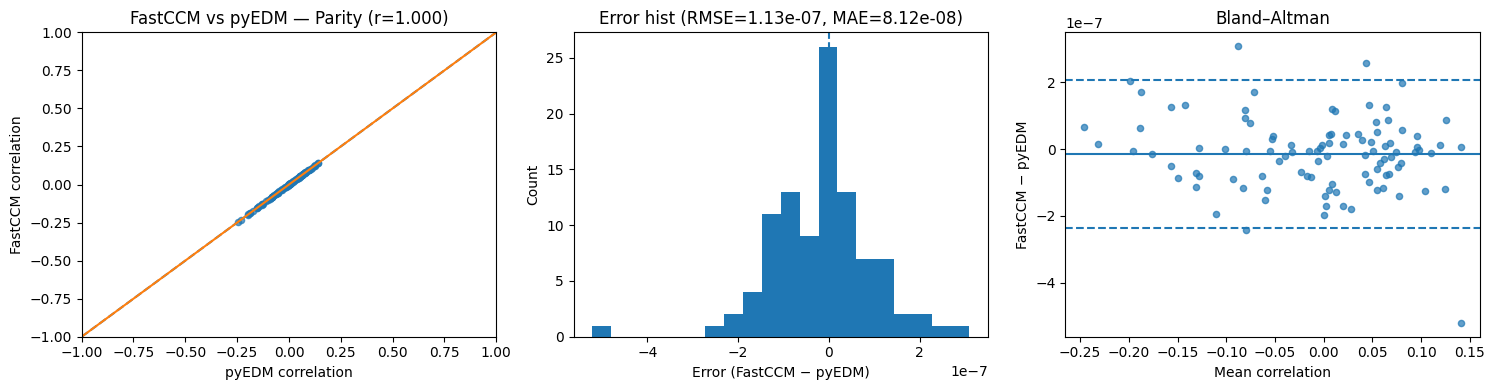

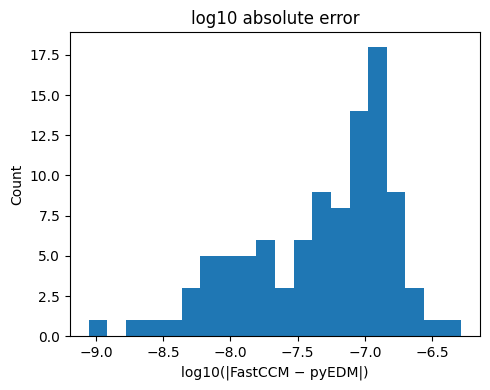

In [26]:
metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)


In [39]:

X = np.random.normal(0,10,200)
Y = np.random.uniform(0,10,200)
df = pd.DataFrame([X,Y],index=["X","Y"]).T
pyEDM.SMap(df,columns="X",target="Y",lib="1 200", pred="1 200", E=3, tau=-1, theta=1, Tp=1, noTime=True,exclusionRadius=0)

{'predictions':       Time  Observations  Predictions  Pred_Variance
 0      3.0      5.518188          NaN            NaN
 1      4.0      9.520889     4.985141       9.386651
 2      5.0      1.856021     4.471857       9.621559
 3      6.0      9.386464     4.846849       9.538332
 4      7.0      4.206758     5.265111       9.515403
 ..     ...           ...          ...            ...
 194  197.0      8.580513     5.808867      10.122960
 195  198.0      2.142962     4.857756       9.450837
 196  199.0      2.020527     4.682781       9.623371
 197  200.0      5.777122     4.835152       9.715481
 198  201.0           NaN     4.089332       9.909929
 
 [199 rows x 4 columns],
 'coefficients':       Time        C0  ∂Y/∂X(t-0)  ∂Y/∂X(t-1)  ∂Y/∂X(t-2)
 0      3.0       NaN         NaN         NaN         NaN
 1      4.0  4.925985   -0.038654    0.057057    0.041499
 2      5.0  4.948752   -0.033974    0.029572    0.047577
 3      6.0  4.865728   -0.047107    0.009518    0.060680
 4  

In [40]:
X_to_Y_res_FastCCM = []
X_to_Y_res_pyEDM = []

np.random.seed(1)

for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").compute(X_emb = X_emb,
                                                Y_emb = Y_emb,
                                                library_size = 200,
                                                sample_size = 200, exclusion_window=0, tp=1, method="smap",seed=1, trials=1, theta=1)

    pyedm_ccm_res = pyEDM.SMap(df,columns="X",target="Y",lib="1 200", pred="1 200", E=3, tau=-1, theta=1, Tp=1, noTime=True,exclusionRadius=0)
    
    X_to_Y_res_FastCCM += [fast_ccm_res[-1].squeeze()]
    X_to_Y_res_pyEDM += [pyedm_ccm_res["predictions"][["Observations", "Predictions"]].corr()["Predictions"]["Observations"]]


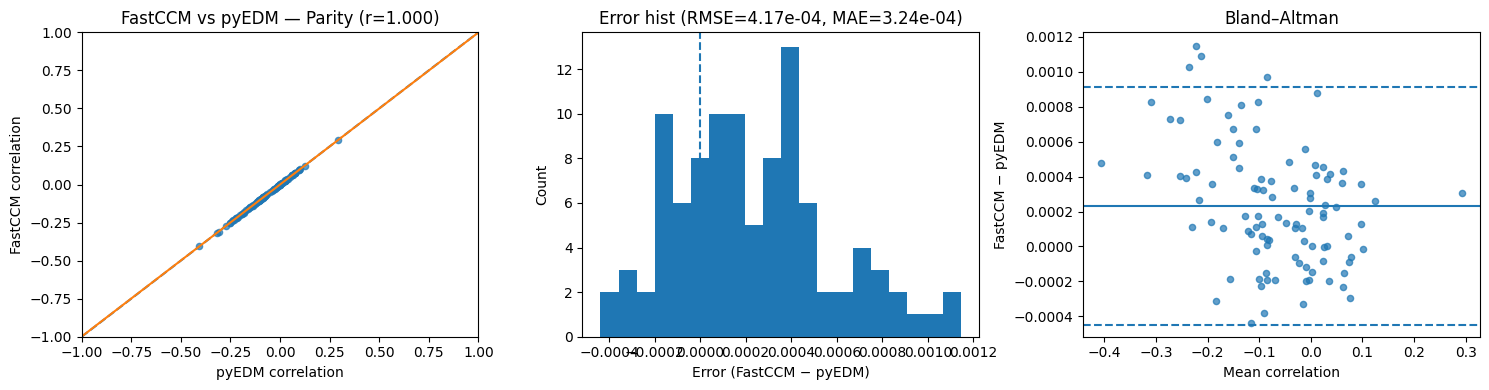

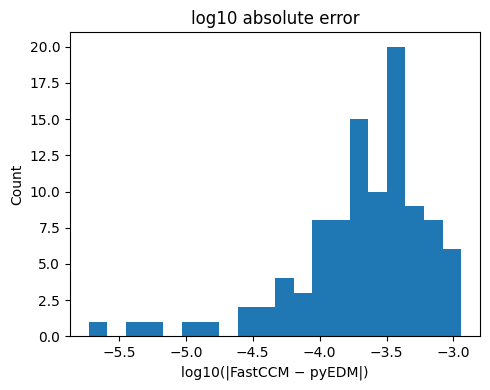

In [41]:
metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)


In [42]:
X_to_Y_res_FastCCM = []
X_to_Y_res_pyEDM = []

np.random.seed(1)
tp = 1

for _ in range(100):
    X = np.random.normal(0,10,200)
    Y = np.random.uniform(0,10,200)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    fast_ccm_res = PairwiseCCM("cpu").predict(X_lib_emb = X_emb[:,0:99],
                                                Y_lib_emb = Y_emb[:,0:99],
                                                X_pred_emb = X_emb[:,98:-tp],
                                                library_size = 200, exclusion_window=None, tp=tp, method="smap",seed=1, trials=1, theta=2)


    pyedm_ccm_res = pyEDM.SMap(df,columns="X",target="Y",lib="1 101", pred="101 200", E=3, tau=-1, Tp=tp, noTime=True, theta=2, exclusionRadius=0)

    X_to_Y_res_FastCCM += [np.corrcoef(fast_ccm_res[:,-1,0,0], Y_emb[0,-(100-tp):,-1])[0,1]]
    X_to_Y_res_pyEDM += [pyedm_ccm_res["predictions"][["Observations", "Predictions"]].corr()["Predictions"]["Observations"]]


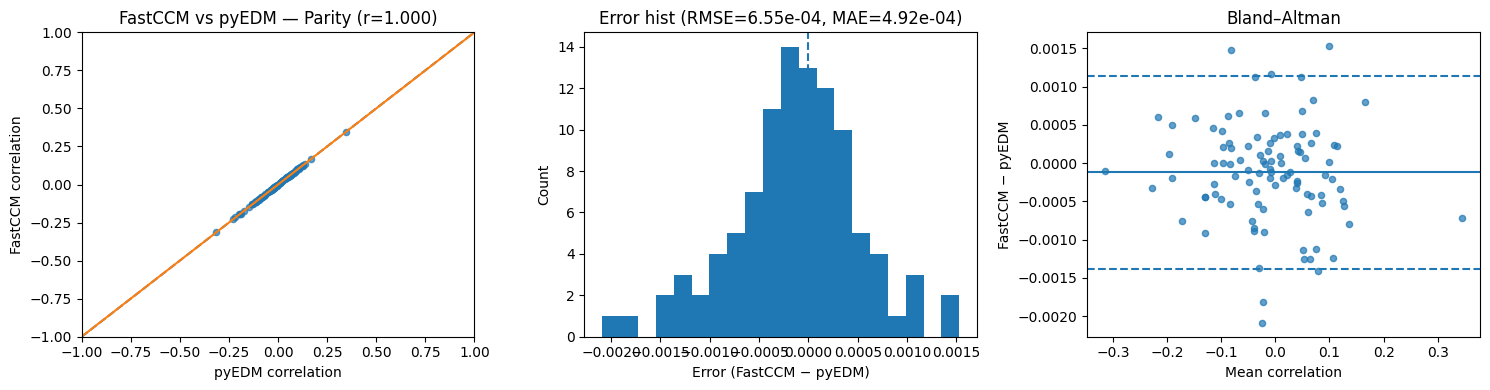

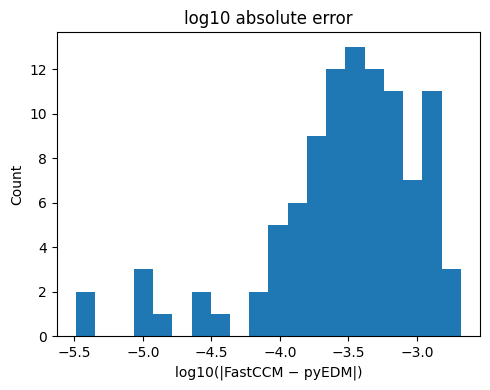

In [43]:
metrics, (fig, axes) = plot_ccm_agreement(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)


---

In [44]:
test_df = pd.read_csv("https://raw.githubusercontent.com/SugiharaLab/pyEDM/refs/heads/master/src/pyEDM/data/circle.csv")
val_df = pd.read_csv("https://raw.githubusercontent.com/SugiharaLab/pyEDM/refs/heads/master/src/pyEDM/tests/validation/SMap_circle_E2_embd_valid.csv")

In [45]:

X_emb = test_df[["x","y"]].to_numpy()[None]
y_emb = val_df["Observations"].to_numpy()[:-1][None,:,None]
y_val = val_df["Predictions"][1:].to_numpy()

Text(0.5, 0, 'error')

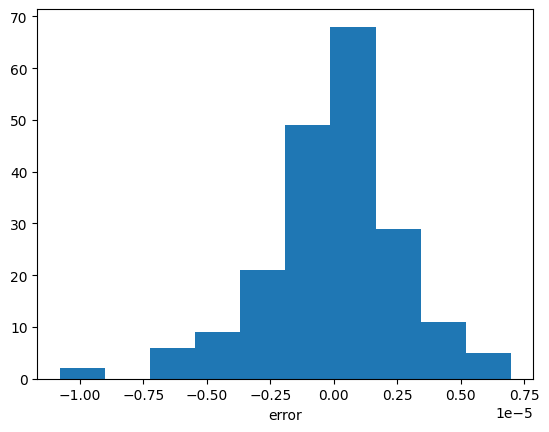

In [46]:
plt.hist(ccm.predict(X_emb,X_emb[:,:,[0]],tp=1,exclusion_rad=0,method="smap",theta=3).squeeze()-y_val[:])
plt.xlabel("error")

In [47]:
test_df = pd.read_csv("https://raw.githubusercontent.com/SugiharaLab/pyEDM/refs/heads/master/src/pyEDM/data/sardine_anchovy_sst.csv")

In [48]:
spx_prices = [ 31.0,  # 1920-1929
    17.4, 12.0, 5.6, 9.4, 9.6, 13.1, 18.0, 12.8, 13.1, 12.0,  # 1930-1939
    10.8, 9.2, 10.4, 12.7, 15.3, 18.4, 18.1, 15.3, 16.2, 16.9,  # 1940-1949
    20.4, 23.8, 26.6, 24.8, 35.9, 45.5, 46.7, 39.0, 55.2, 59.9,  # 1950-1959
    58.1, 71.6, 63.1, 75.0, 84.8, 92.4, 80.3, 96.5, 103.0, 92.0,  # 1960-1969
    92.2, 102.1, 118.1, 97.6, 68.6, 90.2, 107.5, 95.1, 96.1, 107.9,  # 1970-1979
    135.8, 122.6, 140.6, 164.9, 167.2, 211.3, 242.2, 247.1, 277.7, 353.4,  # 1980-1989
    330.2, 417.1, 435.7, 466.3, 459.3, 615.9, 740.7, 970.4, 1229.2, 1469.3,  # 1990-1999
    1320.3, 1148.1, 879.8, 1111.9, 1211.9, 1248.3, 1418.3,
]


In [49]:
test_df["snp500"] = np.log(spx_prices)

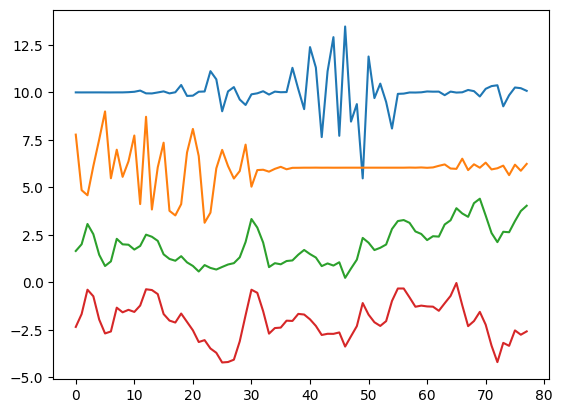

In [50]:
plt.plot(test_df["anchovy"]+10)
plt.plot(test_df["sardine"]+6)
plt.plot(test_df["sio_sst"]+2)
plt.plot(test_df["np_sst"]-2)

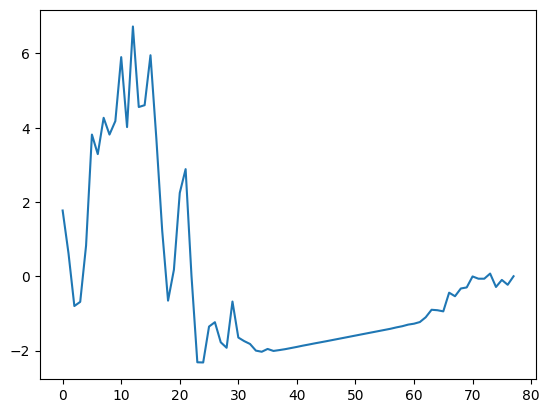

In [51]:
plt.plot(np.cumsum(test_df["sardine"]))

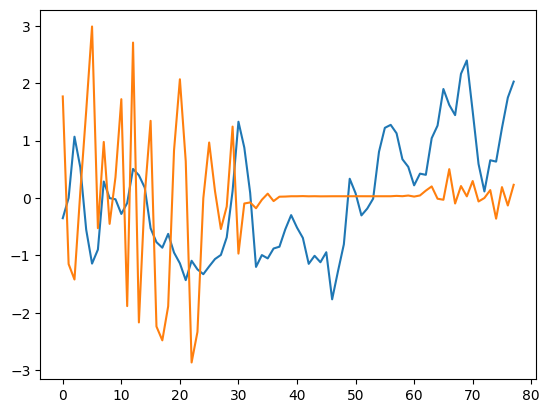

In [52]:
plt.plot((test_df["sio_sst"]))
plt.plot(test_df["sardine"])

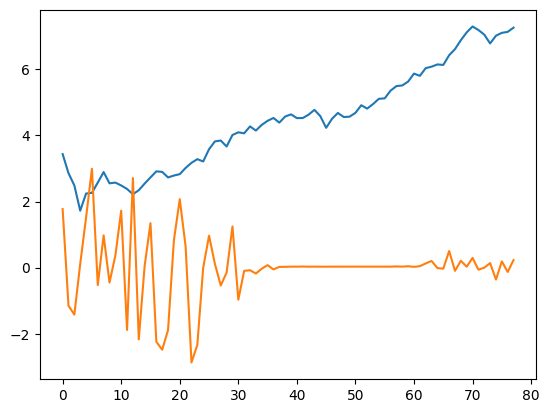

In [53]:
plt.plot((test_df["snp500"]))
plt.plot(test_df["sardine"])

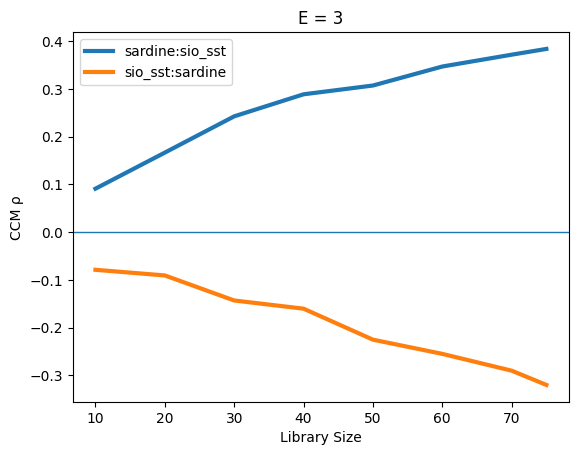

,LibSize,sardine:sio_sst,sio_sst:sardine
0,10,0.090861,-0.079050
1,20,0.166419,-0.090864
2,30,0.242379,-0.143310
3,40,0.288553,-0.160457
4,50,0.306940,-0.225386
5,60,0.346741,-0.255154
6,70,0.371520,-0.290336
7,75,0.383590,-0.320169


In [54]:
pyEDM.CCM( dataFrame = test_df, columns = 'sardine', target = 'sio_sst',
                      libSizes = [10,20,30,40,50,60,70,75], sample = 100,
                      E = 3, Tp = 0, tau = -1, seed = 777 ,showPlot=True)

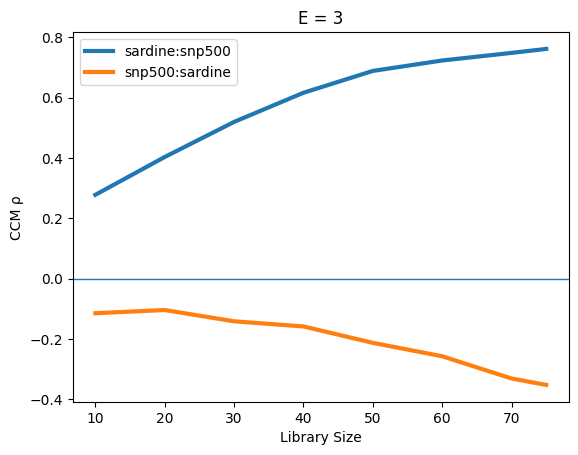

,LibSize,sardine:snp500,snp500:sardine
0,10,0.277616,-0.114652
1,20,0.402874,-0.103958
2,30,0.519120,-0.141341
3,40,0.615664,-0.158387
4,50,0.688038,-0.212675
5,60,0.722592,-0.257174
6,70,0.747814,-0.330819
7,75,0.760943,-0.352103


In [55]:
pyEDM.CCM( dataFrame = test_df, columns = 'sardine', target = 'snp500',
                      libSizes = [10,20,30,40,50,60,70,75], sample = 100,
                      E = 3, Tp = 0, tau = -1, seed = 777 ,showPlot=True)

In [56]:
X_emb = np.transpose(utils.get_td_embedding_np(test_df["sardine"].to_numpy()[:,None],3,1),(1,0,2)).T
Y_emb = np.transpose(utils.get_td_embedding_np((test_df["sio_sst"].to_numpy())[:,None],3,1),(1,0,2)).T

surr_data = pyEDM.AuxFunc.SurrogateData(test_df,"sio_sst",numSurrogates=100).to_numpy()[:,1:]

Y_emb_surr = np.transpose(utils.get_td_embedding_np(surr_data,3,1),axes=(2,0,1))
#Y_emb_surr = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,100)),3,1),axes=(2,0,1))+ (np.arange(0,76)/20)[None,:,None]
X_emb_surr = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,1)),3,1),axes=(2,0,1))+ (np.arange(0,76)/20)[None,:,None]

/Users/iaroslav/miniconda3/envs/FlowDec/lib/python3.9/site-packages/pyEDM/AuxFunc.py:160: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[ s + 1 ] = scaled


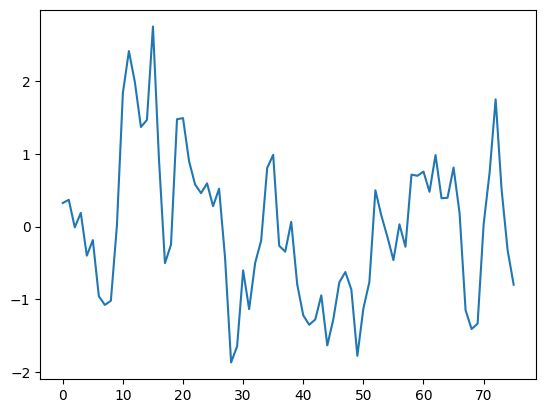

In [57]:
plt.plot(Y_emb_surr[0,:,2])

In [49]:
conv_res = CCM_utils.Functions("cpu").convergence_test(X = X_emb,
                                                                Y = Y_emb,
                                        subset_sizes = [10,20,30,40,50,60,70,75],
                                        subsample_size=1000, exclusion_rad=1, tp=0, method="simplex",trials=100)

In [50]:
conv_res_surr = CCM_utils.Functions("cpu").convergence_test(X = X_emb,
                                                                Y = Y_emb_surr,
                                        subset_sizes = [10,20,30,40,50,60,70,75],
                                        subsample_size=1000, exclusion_rad=1, tp=0, method="simplex",trials=1)

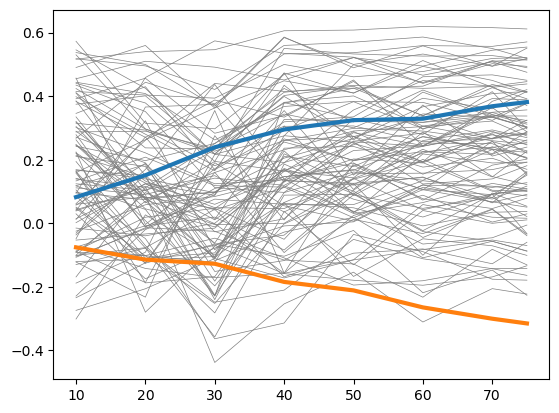

In [51]:


plt.plot(conv_res_surr["subset_sizes"],conv_res_surr["X_to_Y"][:,:,-1].mean(axis=1)[:,:,0],color='gray',lw=0.5)
plt.plot(conv_res["subset_sizes"],conv_res['X_to_Y'][:,:,-1,0].mean(axis=1).squeeze(),zorder=10,lw=3)
plt.plot(conv_res["subset_sizes"],conv_res['Y_to_X'][:,:,-1,0].mean(axis=1).squeeze(),zorder=10,lw=3)

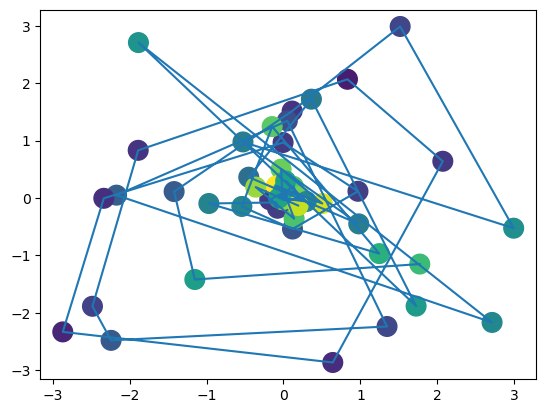

In [24]:
plt.scatter(test_df["sardine"][:-2],test_df["sardine"][1:-1],c=test_df["sio_sst"][2:],s=200)
plt.plot(test_df["sardine"][:-2],test_df["sardine"][1:-1])

In [25]:
def generate_ebisuzaki_surrogates(x):
    n = len(x)

    Xf = np.fft.fft(x)
    amplitudes = np.abs(Xf)
    phases = np.angle(Xf)

    random_phases = np.zeros(n, dtype=np.float64)
    random_phases[0] = phases[0]  # Keep the zero frequency component unchanged

    if n % 2 == 0:
        random_phases[n // 2] = phases[n // 2]  # Nyquist frequency component
        pos_freq = np.arange(1, n // 2)
    else:
        pos_freq = np.arange(1, (n + 1) // 2)

    random_phases[pos_freq] = np.random.uniform(0, 2 * np.pi, size=len(pos_freq))
    # Ensure Hermitian symmetry for negative frequencies
    random_phases[-pos_freq] = -random_phases[pos_freq]

    surrogate_spectrum = amplitudes * np.exp(1j * random_phases)

    surrogate_x = np.fft.ifft(surrogate_spectrum).real

    return surrogate_x

In [161]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(test_df["sio_sst"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -0.760677863835497
p-value: 0.8304007257706593


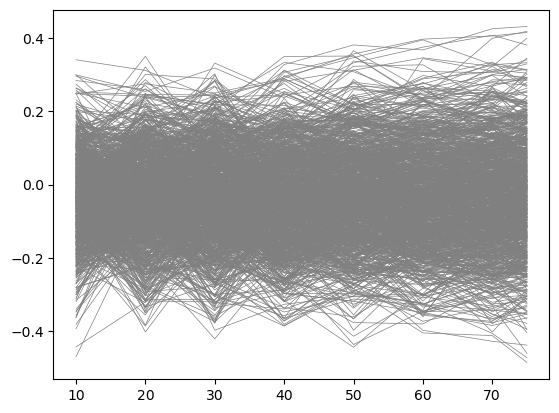

In [106]:

X_emb_rand = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,1)),3,1),axes=(2,0,1))
Y_emb_rand = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,1000)),3,1),axes=(2,0,1))

conv_res_rand = CCM_utils.Functions("cpu").convergence_test(X = X_emb_rand,
                                                                Y = Y_emb_rand,
                                        subset_sizes = [10,20,30,40,50,60,70,75],
                                        subsample_size=1000, exclusion_rad=1, tp=0, method="simplex",trials=1)
plt.plot(conv_res_rand["subset_sizes"],conv_res_rand["X_to_Y"][:,:,-1].mean(axis=1)[:,:,0],color='gray',lw=0.5)
plt.show()

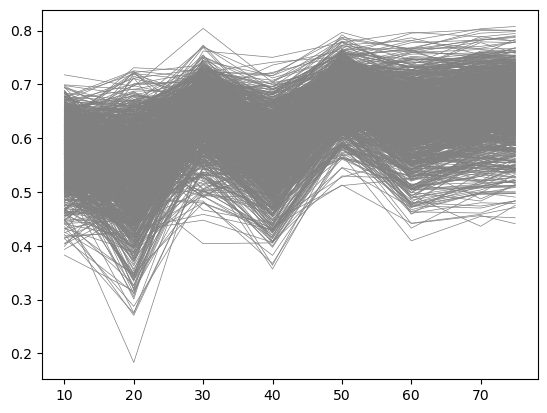

In [108]:

X_emb_rand = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,1)),3,1),axes=(2,0,1)) * (np.arange(0,76)/25)[None,:,None]
Y_emb_rand = np.transpose(utils.get_td_embedding_np(np.random.normal(0,1,(78,1000)),3,1),axes=(2,0,1)) + (np.arange(0,76)/10)[None,:,None]

conv_res_rand = CCM_utils.Functions("cpu").convergence_test(X = X_emb_rand,
                                                                Y = Y_emb_rand,
                                        subset_sizes = [10,20,30,40,50,60,70,75],
                                        subsample_size=1000, exclusion_rad=1, tp=0, method="simplex",trials=1)
plt.plot(conv_res_rand["subset_sizes"],conv_res_rand["X_to_Y"][:,:,-1].mean(axis=1)[:,:,0],color='gray',lw=0.5)
plt.show()